## Introduction

In this assignment, you are going to build a classifier for named entities from the Groningen Meaning Bank corpus.  Named entity recognition (NER) takes noun phrases from a text and identifies whether they are persons, organizations, and so on.  You will be using the Groningen Meaning Bank named entity corpus available on mltgpu at `/scratch/lt2222-v21-resources/GMB_dataset.txt`.  In this version of the task, you will assume we know *that* something is a named entity, and instead use multi-class classification to identify its type.  So you will be doing named entity classification but *not* recognition.

The data looks like this: 

```
3996    182.0   Nicole  NNP     B-per
3997    182.0   Ritchie NNP     I-per
3998    182.0   is      VBZ     O
3999    182.0   pregnant        JJ      O
4000    182.0   .       .       O
4001    183.0   Speaking        VBG     O
4002    183.0   to      TO      O
4003    183.0   ABC     NNP     B-org
4004    183.0   News    NNP     I-org
4005    183.0   interviewer     NN      O
4006    183.0   Dianne  NNP     B-per
4007    183.0   Sawyer  NNP     I-per
4008    183.0   ,       ,       O
4009    183.0   the     DT      O
4010    183.0   25-year-old     JJ      O
4011    183.0   co-star NN      O
4012    183.0   of      IN      O
4013    183.0   TV      NN      O
4014    183.0   's      POS     O
4015    183.0   The     DT      B-art
4016    183.0   Simple  NNP     I-art
4017    183.0   Life    NNP     I-art
4018    183.0   said    VBD     O
4019    183.0   she     PRP     O
4020    183.0   is      VBZ     O
4021    183.0   almost  RB      O
4022    183.0   four    CD      O
4023    183.0   months  NNS     O
4024    183.0   along   IN      O
4025    183.0   in      IN      O
4026    183.0   her     PRP$    O
4027    183.0   pregnancy       NN      O
4028    183.0   .       .       O
```

The first column is the line number.  The second column is a sentence number (for some reason given as a float; ignore it).  The third column is the word.  The fourth column is a part of speech (POS) tag in Penn Treebank format.  The last column contains the named entity annotation. 

The annotation works like this.  Every `O` just means that the row does not represent a named entity.  `B-xyx` means the first word in a named entity with type `xyx`. `I-xyz` means the second and later words of an `xyz` entity, if there are any.  That means that every time there's a `B` or an `I`, there's a named entity.  

The entity types in the corpus are `art`,
`eve`,
`geo`,
`gpe`,
`nat`,
`org`,
`per`,
and `tim`

Your task is the following.
1. To preprocess the text (lowercase and lemmatize; punctuation can be preserved as it gets its own rows).
2. To create instances from every from every identified named entity in the text with the type of the NE as the class, and a surrounding context of five words on either side as the features.  
3. To generate vectors and split the instances into training and testing datasets at random.
4. To train a support vector machine (via `sklearn.svm.LinearSVC`) for classifying the NERs.
5. To evaluate the performance of the classifier.

You will do this by modifying a separate file containing functions that will be called from this notebook as a module.  You can modify this notebook for testing purposes but please only submit the original.  You will document everything in Markdown in README.md and submit a GitHub repository URL.

This assignment is due on
**Tuesday, 2021 March 9 at 23:59**.  It has **25 points** and **7 bonus points**.

### Installation of libraries

In [ ]:
!pip install -q lazypredict #try to use lazypredict classifier for the first time (optional)
!pip install -q scikit-plot

In [16]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Library Imports

In [37]:
import a2
import pandas as pd
import importlib
import numpy as np
import scikitplot as skplt

from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import plot_confusion_matrix,confusion_matrix

import matplotlib.pyplot as plt

#import lazypredict
#from lazypredict.Supervised import LazyClassifier

## Part 1 - preprocessing (3 points)

See step 1 above.  The data is coming to you as an unused file handle object.  You can return the data in any indexable form you like.  You can also choose to remove infrequent or uninformative words to reduce the size of the feature space. (Document this in README.md.)

In [39]:
gmbfile = open('GMB_dataset.txt', "r")
inputdata = a2.preprocess(gmbfile,remove_stop=True)
inputdata

,Sentence #,Word,POS,Tag,Tag_prefix,Tag_entity,Word_seq
0,1.0,thousand,NNS,O,O,None,1
2,1.0,demonstrator,NNS,O,O,None,2
4,1.0,marched,VBN,O,O,None,3
6,1.0,london,NNP,B-geo,B,geo,4
8,1.0,protest,VB,O,O,None,5
...,...,...,...,...,...,...,...
66155,2999.0,could,MD,O,O,None,6
66157,2999.0,announced,VBN,O,O,None,7
66158,2999.0,within,IN,B-tim,B,tim,8
66159,2999.0,day,NNS,O,O,None,9


In [40]:
inputdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43977 entries, 0 to 66160
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Sentence #  43977 non-null  object
 1   Word        43977 non-null  object
 2   POS         43977 non-null  object
 3   Tag         43977 non-null  object
 4   Tag_prefix  43977 non-null  object
 5   Tag_entity  9736 non-null   object
 6   Word_seq    43977 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 2.7+ MB


## Part 2 - Creating instances (7 points)

Do step 2 above.  You will create a collection of Instance objects.  Remember to consider the case where the NE is at the beginning of a sentence or at the end, or close to either (you can create a special start token for that).  You can also start counting from before the `B` end of the NE mention and after the last `I` of the NE mention. That means that the instances should include things before and after the named entity mention, but not the named entity text itself.

In [65]:
importlib.reload(a2)
instances = a2.create_instances(inputdata,n=5,skip_ne=True)


In [66]:
instances[20:40]

,0,1,2,3,4,5,6,7,8,9
geo,percent,world,smoker,thought,live,alone,S5,S4,S3,S2
geo,S5,world,smoker,thought,live,alone,S5,S4,S3,S2
gpe,S1,S2,S3,S4,S5,military,launched,offensive,hunt,S5
geo,S4,S5,military,launched,offensive,hunt,insurgent,S5,S4,S3
org,S5,military,launched,offensive,hunt,insurgent,S5,S4,S3,S2
nat,die,cancer,soon,greater,death,tuberculosis,malaria,combined,S5,S4
tim,may,rise,27,million,year,17,million,people,dying,disease
org,force,tried,suppress,report,abuse,prisoner,S5,S4,S3,S2
org,S3,S4,S5,document,released,say,S5,S4,S3,S2
org,S3,S4,S5,document,released,say,staff,S5,S4,S3


## Part 3 - Creating the table and splitting (10 points)

Here you're going to write the functions that create a data table with "document" vectors representing each instance and split the table into training and testing sets and random with an 80%/20% train/test split.

In [67]:
bigdf = a2.create_table(instances,method='tfidf')
bigdf[20:40]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:71: FutureWarning: Pass input=['S4 S5 thousand demonstrator marched protest war demand withdrawal S5', 'S5 demonstrator marched protest war demand withdrawal troop country S5', 'S5 protest war demand withdrawal troop country S5 S4 S3', 'S1 S2 S3 S4 S5 official say expect get access', 'access sealed sensitive part plant surveillance system begin functioning S5', 'S5 sealed sensitive part plant surveillance system begin functioning S5', 'S3 S4 S5 helicopter gunships pounded militant hideout tribal S5', 'S5 gunships pounded militant hideout tribal region many militant S5', 'S5 hideout tribal region many militant believed fled avoid earlier', 'avoid earlier military offensive nearby S5 S4 S3 S2 S1', 'S5 earlier military offensive nearby S5 S4 S3 S2 S1', 'S5 global financial crisis left economy shamble S5 S4 S3', 'S3 S4 S5 prime minister refused resign call early S5', 'S3 S4 S5 prime minister refused resign call early electi

,_class_,10,100,103,11,110,119,12,120,123,12th,13,135,14,140,15,150,156,16,160,167,17,171,177,18,185,19,191,19th,20,200,2002,2004,21,22,227,23,24,245,25,...,within,without,witness,witnessed,woman,word,work,worked,worker,working,workload,world,worldwide,worried,worrisome,worry,worsened,worship,worst,worth,would,wound,wounded,wounding,wreath,wreckage,wrested,writer,writes,written,wrongdoing,yankee,year,yet,young,younger,youth,zawahiri,zionist,zone
20,geo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.300605,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,geo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.316714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22,gpe,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23,geo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,org,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25,nat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26,tim,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.316087,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.190485,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27,org,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28,org,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29,org,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
train_X, train_y, test_X, test_y = a2.ttsplit(bigdf)

In [69]:
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(7184, 4085) (7184,) (1796, 4085) (1796,)


In [70]:
len(test_y) / (len(test_y) + len(train_y))

0.2

In [71]:
len(test_X) / (len(test_X) + len(train_X))

0.2

In [72]:
test_y[0]

'per'

## Part 4 - Training the model (0 points)

This part you won't do yourself.

In [ ]:
model = LinearSVC()
model.fit(train_X, train_y)
train_predictions = model.predict(train_X)
test_predictions = model.predict(test_X)

In [ ]:
train_predictions

array(['tim', 'geo', 'gpe', ..., 'org', 'per', 'org'], dtype=object)

In [ ]:
train_y

array(['gpe', 'geo', 'gpe', ..., 'org', 'per', 'org'], dtype=object)

In [ ]:
test_predictions

array(['per', 'per', 'per', ..., 'org', 'geo', 'per'], dtype=object)

In [ ]:
test_y

array(['per', 'org', 'gpe', ..., 'org', 'geo', 'per'], dtype=object)

In [ ]:
#model = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
#model.fit(train_X, train_y)


## Part 5 - Evaluation (5 points)

Investigate for yourself what a "confusion matrix".  Then implement a function that takes the data and produces a confusion matrix in any readable form that allows us to compare the performance of the model by class.  

In [ ]:
model.score(train_X,train_y),model.score(test_X,test_y)

(0.8009465478841871, 0.5027839643652561)

In [ ]:
importlib.reload(a2)
a2.confusion_matrix(test_y, test_predictions)

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

<Figure size 576x576 with 0 Axes>

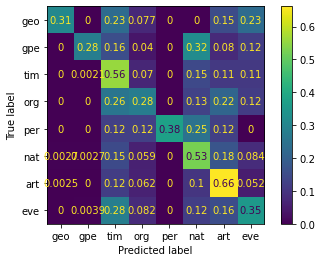

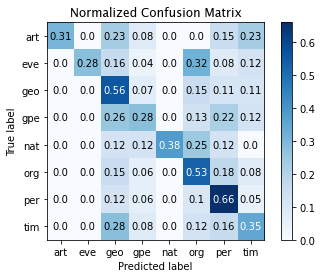

In [ ]:
importlib.reload(a2)

#a2.confusion_matrix(model,test_y, test_predictions)
np.set_printoptions(precision=2)
fig = plt.figure(figsize=(8,8))
class_names = bigdf['_class_'].unique()

disp = plot_confusion_matrix(model,test_X, test_y,
                                 display_labels=class_names,
                                 normalize='true')

confusion_matrix(test_y,test_predictions)


skplt.metrics.plot_confusion_matrix(test_y, test_predictions, normalize=True)

Examine the matrix and describe your observations in README.md.  In particular, what do you notice about the predictions on the training data compared to those on the test data.

## Bonus Part A - Error analysis (2 points)

Look at the weakest-performing classes in the confusion matrix (or any, if they all perform poorly to the same extent).  Find some examples in the test data on which the classifier classified incorrectly for those classes.  What do you think is the reason why those are hard?  Consider linguistic factors and statistical factors, if applicable.  Write your answer in README.md.

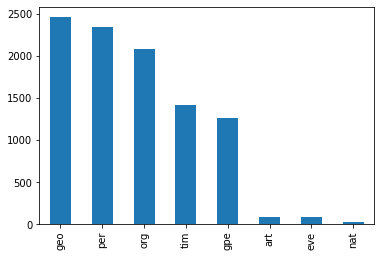

In [74]:
inputdata['Tag_entity'].value_counts().plot(kind='bar')

## Bonus Part B - Expanding the feature space (7 points)

In [64]:
# Code for part B
#Added other properties as dictionary objects
#TO DO
class sentence:
    def __init__(self):
        self.id = None
        self.entities = []
        self.sentence_text = ""
        self.sentence_list = []
        self.length = 0

    def create(self, r):
        self.sentence_id = r[0]
        self.sentence_text = r[1][0]
        self.sentence_list = r[1][1]
        self.entities = r[1][2]

        self.length = len(self.sentence_list)  # number of entities/words present in the sentence
        for entity in self.entities:
            entity.set_parent(self)

    def previous_entities(self, position, n):
        if position > self.length:
            ValueError('Invalid parameter specific for position', position)

        return self.entities[:position - 1][-n:]

    def next_entities(self, position, n):
        if position > self.length:
            ValueError('Invalid parameter specific for position', position)

        return self.entities[position:][:n]

    def get_features(self, n=5, pad=True,skip_ne=True):
        VALID_TAGS = ['art', 'eve', 'geo', 'gpe', 'nat', 'org', 'per', 'tim']
        words = []

        if not isinstance(n, int) or n < 0:
            ValueError('Invalid parameter specific for n', n)

        # Generate features
        encode_strings = ["S{}".format(i) for i in range(1, n + 1)]

        sentence_features = []
        next_features = []
        prev_features = []

        for entity in self.entities:

          # ---previous---
          prev_features = [ent.word for ent in self.previous_entities(entity.position, n) if not (ent.isne and skip_ne)]
          print(entity.__dict__)
          '''
          # paddings
          paddings = encode_strings[len(prev_features):]
          if pad and len(paddings) > 0:
              prev_features = paddings + prev_features

          # ---next---
          next_features = [ent.word for ent in self.next_entities(entity.position, n) if not (ent.isne and skip_ne)]

          # paddings
          paddings = encode_strings[len(next_features):][::-1]
          if pad and len(paddings) > 0:
              next_features = next_features + paddings
          '''

          #concat both prev and next
          sentence_features.append(
              pd.DataFrame.from_dict({entity.tag_entity: prev_features + next_features}, orient='index'))


        # concat all dataframes
        if sentence_features:
            return pd.concat(sentence_features)
        else:
            return pd.DataFrame()


# entity
class entity:
    def __init__(self, word, pos, tag_prefix, tag_entity, position):
        self.word = word
        self.pos  = pos  # part of speech
        self.tag_prefix = tag_prefix
        self.tag_entity = tag_entity
        self.position = position  # position of word in text
        self.isfirst = (position == 1)
        self.islast    = None
        self.isne      = not (tag_entity is None)
        self.isupper   = word.isupper()
        self.istitle   = word.istitle()
        self.isdigit   = word.isdigit() 

    def __str__(self):
        return self.word

    def set_parent(self, parent):
        self.parent = parent
        self.islast = (self.position == parent.length)

    def __dict__(self):
        selected_features = ['word','pos','postion','tag_prefix','isfirst','islast','isne','isupper','istitle','isdigit']

        return {k:super().__dict__[key] for key in selected_features}

class gmb_processor:
    def __init__(self, data):
        self.data = data
        self.df_aggregated_sentences = None
        self.sentences = []

    def __aggregator_fuction(self, s):
        sentence_list = []
        sentence_entities = []
        sentence_text = " "

        #iterate
        position = 0
        for (w, p, tp, te) in (zip(s["Word"].values.tolist(),
                                   s["POS"].values.tolist(),
                                   s["Tag_prefix"].values.tolist(),
                                   s["Tag_entity"].values.tolist())):

            if str(w).isalnum():  # ignore punctuation
                sentence_list.append(w)
                sentence_entities.append(entity(w, p, tp, te, position + 1))
                position = position + 1


        sentence_text = " ".join(sentence_list)

        return pd.Series({"sentence_text": sentence_text,
                          "sentence_list": sentence_list,
                          "sentence_entities": sentence_entities})

    def __aggregate(self):  # Agg df to sentences
        ds_result = self.data.groupby("Sentence #").apply(self.__aggregator_fuction)
        ds_result["Sentence #"] = ds_result.index.astype(float).astype(int)

        return ds_result

    def fit(self):
        # Agg df to sentences
        self.df_aggregated_by_sentence_id = self.__aggregate()

        # Convert df to sentence instance
        for row in self.df_aggregated_by_sentence_id.iterrows():
            sent = sentence()
            sent.create(row)
            self.sentences.append(sent)
        return self.sentences

    def get_instances(self,n, pad,skip_ne):
        if (len(self.df_aggregated_by_sentence_id) == 0) or (len(self.sentences) == 0):
            raise Exception("You need to run fit() first")

        instances = []
        # iterate over all sentences
        for sent in self.sentences:
            instances.append(sent.get_features(n,pad,skip_ne))

        return pd.concat(instances)

def create_instances(data,n=5, pad=True,skip_ne=True):
    #processor
    processor = gmb_processor(data)

    #Convert df to sentences
    sentences = processor.fit()

    print(sentences)

    #return feature instances as a df
    df_instances = processor.get_instances(n=n,pad=pad,skip_ne=skip_ne)
    return df_instances



Run the entire process above, but incorporate part-of-speech tag information into the feature vectors.  It's your choice as to how to do this, but document it in README.md.  Your new process should run from the single call below:

In [ ]:
a2.bonusb('/scratch/lt2222-v21-resources/GMB_dataset.txt')